<a href="https://colab.research.google.com/github/mdiazmat/DSBA6165Project/blob/main/SCIN_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
from google.colab import auth
from google.cloud import storage
auth.authenticate_user()

In [35]:
# This is to double check the bucket contents
!gsutil ls gs://dx-scin-public-data/dataset/

gs://dx-scin-public-data/dataset/scin_app_questions.csv
gs://dx-scin-public-data/dataset/scin_cases.csv
gs://dx-scin-public-data/dataset/scin_label_questions.csv
gs://dx-scin-public-data/dataset/scin_labels.csv
gs://dx-scin-public-data/dataset/images/


In [36]:
import io
import pandas as pd

client = storage.Client(project="dx-scin-public")
bucket = client.bucket("dx-scin-public-data")

def load_csv_from_bucket(filename):
    blob = bucket.blob(f"dataset/{filename}")
    data = blob.download_as_bytes()
    return pd.read_csv(io.BytesIO(data))


In [37]:
# scin_subset_500.csv - simple random sample (baseline)
# scin_subset_balanced.csv - keeps **all urgent** classes & balanced sample of routine
cases_df = load_csv_from_bucket("scin_cases.csv")
labels_df = load_csv_from_bucket("scin_labels.csv")
print("Cases shape:", cases_df.shape)
print("Labels shape:", labels_df.shape)

Cases shape: (5033, 57)
Labels shape: (5033, 17)


In [38]:
# Merge on case_id to attach dermatologist labels to each case record.
scin_df = pd.merge(cases_df, labels_df, on="case_id", how="inner")
print("Merged shape:", scin_df.shape)

Merged shape: (5033, 73)


In [39]:
# These features are the most similar to the derm_transcripts so when we combine them it'll be easier
columns_keep = [
    "case_id",
    "image_1_path",
    "sex_at_birth",
    "fitzpatrick_skin_type",
    "weighted_skin_condition_label", # ex "{'acne': 1.0}"
    "dermatologist_skin_condition_on_label_name"
]
scin_small = scin_df[columns_keep]

In [40]:
scin_small.head(3)

,case_id,image_1_path,sex_at_birth,fitzpatrick_skin_type,weighted_skin_condition_label,dermatologist_skin_condition_on_label_name
0,-1000600354148496558,dataset/images/-3205742176803893704.png,OTHER_OR_UNSPECIFIED,NaN,"{'Inflicted skin lesions': 0.41, 'Eczema': 0.4...","['Inflicted skin lesions', 'Eczema', 'Irritant..."
1,-1002039107727665188,dataset/images/-4762289084741430925.png,OTHER_OR_UNSPECIFIED,NaN,"{'Prurigo nodularis': 0.41, 'SCC/SCCIS': 0.41,...","['Prurigo nodularis', 'Actinic Keratosis', 'SC..."
2,-1003358831658393077,dataset/images/-4027806997035329030.png,MALE,NONE_IDENTIFIED,"{'Impetigo': 0.55, 'Herpes Zoster': 0.23, 'Bul...","['Impetigo', 'Herpes Zoster', 'Bullous dermati..."


In [70]:
import ast

def extract_condition(x):
  """Convert the SCIN `weighted_skin_condition_label` string into a simple label.
  Ex: "{'acne': 1.0}" -> "acne"
  If parsing fails, returns None.
  """
  try:
      d = ast.literal_eval(x)
      if isinstance(d, dict):
          return list(d.keys())[0]
  except Exception:
      return None

# use .loc to avoid SettingWithCopyWarning
scin_small = scin_small.copy()  # make sure we’re working on a real copy
scin_small.loc[:, "condition_clean"] = scin_small["weighted_skin_condition_label"].apply(extract_condition)

In [42]:
scin_small["condition_clean"].value_counts().head(10)

,count
condition_clean,
Eczema,471
Allergic Contact Dermatitis,256
Urticaria,216
Insect Bite,180
Folliculitis,145
Psoriasis,105
Tinea,95
Herpes Zoster,72
Impetigo,69


In [43]:
scin_subset = scin_small.dropna(subset=["condition_clean", "image_1_path"])
scin_subset = scin_subset.sample(n=500, random_state=42)
print("Subset shape:", scin_subset.shape)

Subset shape: (500, 7)


In [44]:
scin_subset.to_csv("scin_subset_500.csv", index=False)
print("Saved subset with columns:", list(scin_subset.columns))

Saved subset with columns: ['case_id', 'image_1_path', 'sex_at_birth', 'fitzpatrick_skin_type', 'weighted_skin_condition_label', 'dermatologist_skin_condition_on_label_name', 'condition_clean']


In [47]:
import ast

scin_small = scin_small.copy()

def extract_condition(x):
    try:
        d = ast.literal_eval(x)
        if isinstance(d, dict):
            return list(d.keys())[0]
    except Exception:
        pass
    return None

scin_small["condition_clean"] = scin_small["weighted_skin_condition_label"].apply(extract_condition)

In [48]:
# triage buckets
URGENT = {
    "melanoma",
    "squamous_cell_carcinoma",
    "basal_cell_carcinoma",
    "cellulitis",
    "shingles"
}


BUDGET = 500                 # total rows you want to keep
RANDOM_STATE = 42

# Always keep all urgent (they're relatively rare)
urgent_df = scin_small[scin_small["condition_clean"].isin(URGENT)].dropna(subset=["image_1_path"])
urgent_df = urgent_df.drop_duplicates(subset=["case_id"])

remaining = max(0, BUDGET - len(urgent_df))

# From the non-urgent pool, sample evenly across conditions
nonurgent_df = scin_small[
    ~scin_small["condition_clean"].isin(URGENT)
].dropna(subset=["image_1_path"]).drop_duplicates(subset=["case_id"])

if remaining > 0 and not nonurgent_df.empty:
    k = nonurgent_df["condition_clean"].nunique()
    per_class_cap = max(5, remaining // max(1, k))

    sampled_nonurgent = (nonurgent_df
        .groupby("condition_clean", group_keys=False)
        .apply(lambda g: g.sample(n=min(per_class_cap, len(g)), random_state=RANDOM_STATE))
    )

    # If we’re still short (because some classes are tiny), top up at random
    if len(sampled_nonurgent) < remaining:
        top_up = nonurgent_df.drop(sampled_nonurgent.index, errors="ignore")
        extra = top_up.sample(
            n=min(remaining - len(sampled_nonurgent), len(top_up)),
            random_state=RANDOM_STATE
        )
        sampled_nonurgent = pd.concat([sampled_nonurgent, extra], ignore_index=True)
else:
    sampled_nonurgent = nonurgent_df.head(0)

scin_subset = (pd.concat([urgent_df, sampled_nonurgent], ignore_index=True)
                 .sample(frac=1, random_state=RANDOM_STATE)
                 .reset_index(drop=True))
print(scin_subset["condition_clean"].value_counts())
print("Final subset size:", len(scin_subset))


condition_clean
Irritant Contact Dermatitis    5
Keratosis pilaris              5
Cellulitis                     5
Granuloma annulare             5
Herpes Zoster                  5
                              ..
Arsenical keratosis            1
Pyoderma                       1
Cat scratch disease            1
Ingrown hair                   1
Clavus                         1
Name: count, Length: 216, dtype: int64
Final subset size: 587


/tmp/ipython-input-2968242384.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=min(per_class_cap, len(g)), random_state=RANDOM_STATE))


In [49]:
# Final
cols_to_save = [
    "case_id", "image_1_path", "fitzpatrick_skin_type", "sex_at_birth",
    "condition_clean", "weighted_skin_condition_label"
]
scin_subset[cols_to_save].to_csv("scin_subset_balanced.csv", index=False)

In [67]:
# Test to see if the "image_url" works with gemini
import os, pandas as pd
from PIL import Image
import requests
import io

GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')
genai.configure(api_key=GOOGLE_API_KEY)

# load your subset CSV
df = pd.read_csv("scin_subset_balanced.csv")  # or your file name

# If you only have 'image_1_path' (GCS-style), build public HTTPS URLs
if "image_url" not in df.columns:
    base_url = "https://storage.googleapis.com/dx-scin-public-data/"
    df["image_url"] = base_url + df["image_1_path"].astype(str)

# pick one row to test
row = df.sample(1, random_state=7).iloc[0]
img_url = row["image_url"]

# download image bytes and open with PIL
resp = requests.get(img_url, timeout=20)
resp.raise_for_status()
img = Image.open(io.BytesIO(resp.content)).convert("RGB")

# call Gemini with image only
model = genai.GenerativeModel("gemini-2.5-flash")
prompt = "Briefly describe notable skin findings in this image for triage (no diagnosis)."

result = model.generate_content([prompt, img])
print("Image URL:", img_url)
print("Model output:\n", result.text)

# Multi-image case (SCIN often has up to 3 photos per case)
# Build up to 3 URLs for a case, send them all at once
parts = [prompt]
for col in ["image_1_path", "image_2_path", "image_3_path"]:
    if col in df.columns and pd.notna(row.get(col)):
        url = "https://storage.googleapis.com/dx-scin-public-data/" + row[col]
        r = requests.get(url, timeout=20); r.raise_for_status()
        parts.append(Image.open(io.BytesIO(r.content)).convert("RGB"))

result = model.generate_content(parts)
print(result.text)

Image URL: https://storage.googleapis.com/dx-scin-public-data/dataset/images/-1866682450754729316.png
Model output:
 A small, solitary, raised lesion is present on the skin. It appears hypopigmented, with a grayish-white or bluish-white hue, contrasting with the surrounding brown skin. The lesion has an irregular, somewhat rounded shape, and a smooth, possibly firm, dome-shaped or nodular texture. Its borders are distinct. The surrounding skin shows normal skin lines and pigmentation, with no obvious erythema, scaling, or ulceration visible.
A single, elevated, irregularly shaped papule or small nodule is noted on the dorsal aspect of the foot or ankle, in skin of color. The lesion measures approximately 0.5-1 cm and exhibits a mottled bluish-gray to off-white discoloration. Its borders appear relatively well-demarcated. The surrounding skin shows prominent skin lines and appears somewhat dry.


In [53]:
N = 5
subset = df.sample(N, random_state=11)

model = genai.GenerativeModel("gemini-2.5-flash")
prompt = "Summarize visible findings for triage (one sentence)."

for i, r in subset.iterrows():
    try:
        url = r["image_url"]
        b = requests.get(url, timeout=20); b.raise_for_status()
        img = Image.open(io.BytesIO(b.content)).convert("RGB")
        out = model.generate_content([prompt, img])
        print(f"\n[{r.get('case_id', i)}] {url}\n-> {out.text}")
    except Exception as e:
        print(f"\n[{r.get('case_id', i)}] error: {e}")


[-7596615648821174505] https://storage.googleapis.com/dx-scin-public-data/dataset/images/-7977918662336049951.png
-> The image shows a foot and ankle with widespread, raised, pale, and mildly erythematous skin lesions, consistent with urticaria.

[-6195806766943101605] https://storage.googleapis.com/dx-scin-public-data/dataset/images/6540654300986766423.png
-> The forearm presents with numerous scattered, reddish-purple macules and small papules, suggestive of petechiae or small purpura.

[-1003358831658393077] https://storage.googleapis.com/dx-scin-public-data/dataset/images/-4027806997035329030.png
-> On the inner arm, there is an erythematous, irregular patch with raised, crusted borders and surrounding scattered smaller erythematous papules.

[1229070467125832584] https://storage.googleapis.com/dx-scin-public-data/dataset/images/-4521925482868333629.png
-> Visible findings include a central erythematous and crusted lesion, along with scattered smaller erythematous papules on the s

In [65]:
def show_img_and_gemini(row, prompt="Describe findings for triage (no diagnosis)."):
    # Download bytes
    resp = requests.get(row["image_url"], timeout=20); resp.raise_for_status()
    img = Image.open(io.BytesIO(resp.content)).convert("RGB")

    # Gemini call
    result = model.generate_content([prompt, img])
    text = (result.text or "").strip()

    # Side-by-side preview
    fig, ax = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={"width_ratios":[1.2, 1]})
    ax[0].imshow(img); ax[0].axis("off")
    title_left = f"case_id: {row.get('case_id','?')}\ncondition: {row.get('condition_clean','?')}\nFST: {row.get('fitzpatrick_skin_type','?')}"
    ax[0].set_title(title_left, fontsize=10, loc="left")

    ax[1].axis("off")
    ax[1].text(0, 1, "Gemini output:", fontsize=12, weight="bold", va="top")
    ax[1].text(0, 0.95, text, fontsize=11, va="top", wrap=True, transform=ax[1].transAxes)
    plt.tight_layout()
    plt.show()

    print("Image URL:", row["image_url"])
    print("Gemini output:\n", text)


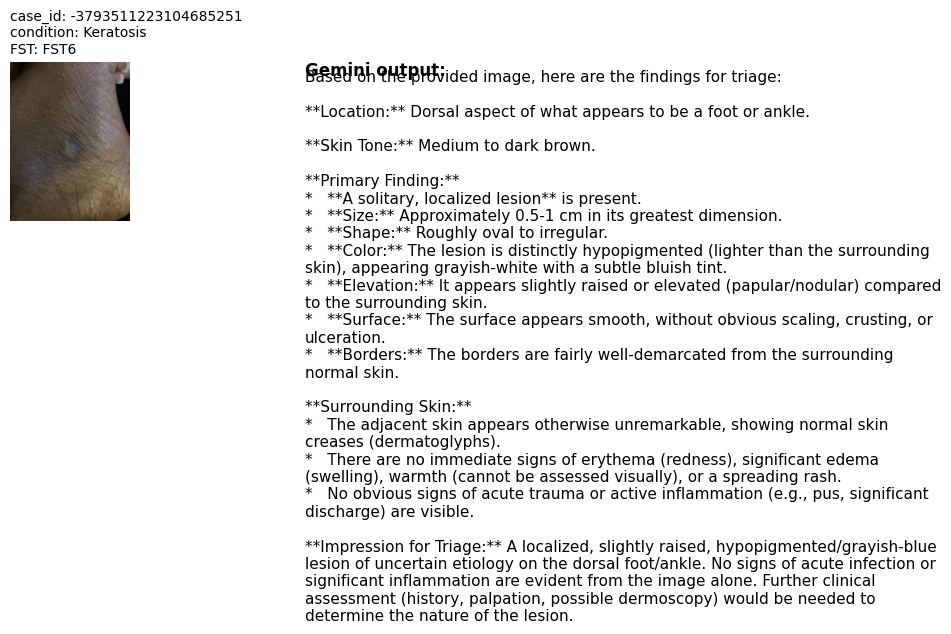

Image URL: https://storage.googleapis.com/dx-scin-public-data/dataset/images/-1866682450754729316.png
Gemini output:
 Based on the provided image, here are the findings for triage:

**Location:** Dorsal aspect of what appears to be a foot or ankle.

**Skin Tone:** Medium to dark brown.

**Primary Finding:**
*   **A solitary, localized lesion** is present.
*   **Size:** Approximately 0.5-1 cm in its greatest dimension.
*   **Shape:** Roughly oval to irregular.
*   **Color:** The lesion is distinctly hypopigmented (lighter than the surrounding skin), appearing grayish-white with a subtle bluish tint.
*   **Elevation:** It appears slightly raised or elevated (papular/nodular) compared to the surrounding skin.
*   **Surface:** The surface appears smooth, without obvious scaling, crusting, or ulceration.
*   **Borders:** The borders are fairly well-demarcated from the surrounding normal skin.

**Surrounding Skin:**
*   The adjacent skin appears otherwise unremarkable, showing normal skin cr

In [66]:
show_img_and_gemini(df.sample(1, random_state=9).iloc[0])